In [1]:
import sys
import platform
sys.path.append('./src/')

if platform.system() == "Windows":
    print("Running on windows")

    %cd ./src/datasets
    !cmd /C get_datasets.cmd
    %cd ..
else:
    print("Running on Mac or linux")

    %cd ./src/datasets
    !bash get_datastets.sh
    %cd ..

Running on windows
D:\Deep Learning\Stanford CS231n\assignment1\src\datasets

(deepenv) D:\Deep Learning\Stanford CS231n\assignment1\src\datasets>IF NOT EXIST "cifar-10-batches-py" (
certutil -urlcache -split -f "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz" cifar-10-python.tar.gz  
 tar -xzvf cifar-10-python.tar.gz  
 del cifar-10-python.tar.gz 
) 
D:\Deep Learning\Stanford CS231n\assignment1\src


# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise, you will:

- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
# Run some setup for this notebook.

import random
import numpy as np
from src.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set the default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
from IPython.core.ultratb import VerboseTB
VerboseTB._tb_highlight = "bg:#039dfc"

## CIFAR-10 Data Loading and Preprocessing

In [3]:
#Load the raw CIFAR-10 data.
cifar10_dir = 'datasets/cifar-10-batches-py'

X_train = y_train = X_test = y_test = None
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


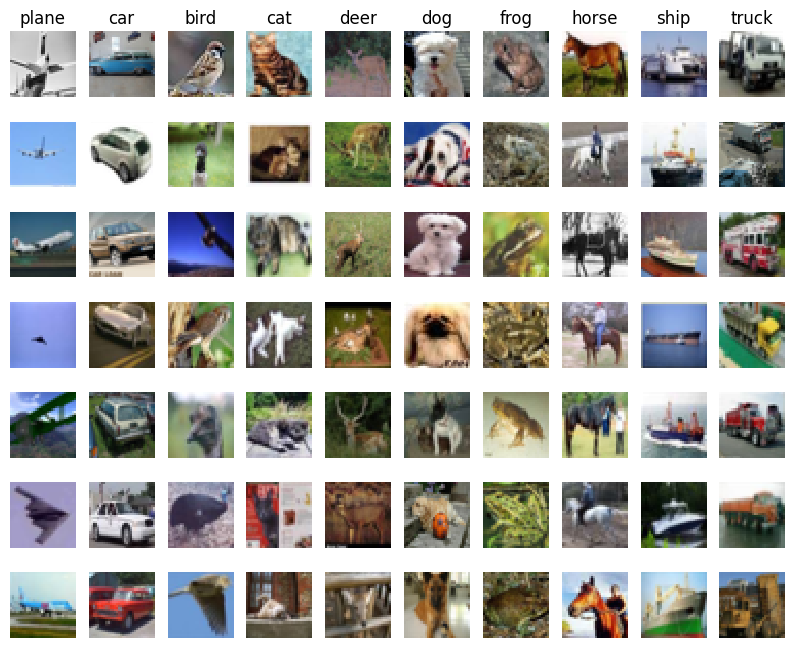

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.

# The list below is actually english representation of the y labels in the same order by indices.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7

for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y) # get all those examples that have y label
    idxs = np.random.choice(idxs, samples_per_class, replace=True) # sample 7 images

    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1 # adding 1 because index starts at 1 in plt.subplot

        # 3 integers (nrows, ncols, index)
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)

plt.show()

In [5]:
# Split the data into train, validation, and test sets. In addition, we will
# create a small development set as a subset of the training set;
# we can use this for development, so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our Validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


In [6]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (10000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


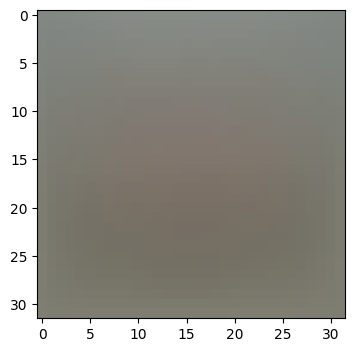

(49000, 3073) (1000, 3073) (10000, 3073) (500, 3073)


In [7]:
# Preprocessing: Mean centering, i.e., subtract the mean image

# First: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[: 10])  # print a few of the elements
plt.figure(figsize=(4, 4))
plt.imshow(mean_image.reshape((32, 32, 3)).astype('uint8'))  # visualize the mean image
plt.show()

# Second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Third: append the bias dimension of ones (i.e., bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix of W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **`src/classifiers/linear_svm.py`**.

As you can see, we have prefilled the function ***`svm_loss_naive`*** which uses for loops to evaluate the multiclass SVM loss function.

In [8]:
# Evaluate the native implementation of the loss we provided for you:
import time
from src.classifiers.linear_svm import svm_loss_naive

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001

loss, _ = svm_loss_naive(W=W, X=X_dev, y=y_dev, reg=0.000005)
print(f"loss: {loss}")

loss: 8.809646761972424


The ***grad*** returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function **`svm_loss_naive`**. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
_, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all the dimensions.
from src.gradient_check import grad_check_sparse
f = lambda weight: svm_loss_naive(weight, X_dev, y_dev, 0.0)[0] # lambda that computes the functional value at w.
grad_check_sparse(f, W, grad, num_checks=15)

numerical: -24.195556 analytic: -24.195556, relative error: 5.592514e-12
numerical: 8.250215 analytic: 8.105715, relative error: 8.834766e-03
numerical: -5.387069 analytic: -5.387069, relative error: 8.515390e-11
numerical: -10.220035 analytic: -10.220035, relative error: 1.304419e-11
numerical: 19.249666 analytic: 19.249666, relative error: 1.366628e-11
numerical: -8.733293 analytic: -8.733293, relative error: 1.861614e-11
numerical: -34.922825 analytic: -34.919713, relative error: 4.456421e-05
numerical: 0.897601 analytic: 0.897601, relative error: 1.655079e-10
numerical: 17.424276 analytic: 17.215775, relative error: 6.019068e-03
numerical: -13.348501 analytic: -13.348501, relative error: 2.006737e-11
numerical: -8.273993 analytic: -8.273993, relative error: 1.392189e-11
numerical: 10.491596 analytic: 10.491596, relative error: 1.191299e-11
numerical: -0.925223 analytic: -0.925223, relative error: 2.235751e-10
numerical: 7.362174 analytic: 7.362174, relative error: 6.721374e-11
nume

In [10]:
# do the gradient check nce again with regularization turned on
# you didn't forget the regularization gradient, did you?
_, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda weight: svm_loss_naive(weight, X_dev, y_dev, 5e1)[0]
grad_check_sparse(f, W, grad, num_checks=15)

numerical: -5.322122 analytic: -5.322122, relative error: 7.100325e-11
numerical: -2.220218 analytic: -2.220218, relative error: 1.715300e-10
numerical: 4.953608 analytic: 4.953608, relative error: 3.784112e-12
numerical: -7.242318 analytic: -7.245556, relative error: 2.235344e-04
numerical: 12.385752 analytic: 12.385752, relative error: 1.064021e-11
numerical: -15.486070 analytic: -15.486070, relative error: 8.808906e-12
numerical: 13.220256 analytic: 13.220256, relative error: 1.524258e-11
numerical: 11.113050 analytic: 11.113050, relative error: 9.329308e-13
numerical: 2.129559 analytic: 2.129559, relative error: 3.086881e-11
numerical: 8.951131 analytic: 8.951131, relative error: 3.480515e-11
numerical: 14.236808 analytic: 14.236808, relative error: 5.635333e-13
numerical: 7.968192 analytic: 7.968192, relative error: 2.373033e-11
numerical: -37.249050 analytic: -37.180117, relative error: 9.261583e-04
numerical: 6.883359 analytic: 6.883359, relative error: 6.150602e-12
numerical: 2

**Inline Question 1**

It is possible that once in a while a dimension in the grad check will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change in the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\textcolor{yellow}{\textit Your Answer:}$ *Yes this is possible, especially at the point where the margin is less than or equal to 0 for a specific class because we take $max(0, x)$ and for x <= 0 we get 0 and for x > 0 we have a straight line this leads to a kink (pointy curve) in the graph and kinks are non-differentiable (because the limit at left and right doesn't match). To see, the analytic gradient will be 0 but the numerical can't be considered the case where $x = 0$ and $h = 1e-5$ then $f(x + h) = max(0, 0 + h) = h$, hence we incur some error. Generally, speaking, smaller margin means frequent errors as we remain at the boundary of 0.*

**Note:** Generally speaking, most of the functions we encounter in neural networks are non-differentiable, but we use a trick called as sub-gradient (taking the gradient of the nearest differentiable point) to solve this issue.

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a bit.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print(f"Naive loss: {loss_naive} computed in {toc - tic}")

from src.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print(f"Vectorized loss: {loss_naive} computed in {toc - tic}")

# The losses should match out, but your vectorized implementation should be much faster
print(f"Difference: {loss_naive - loss_vectorized}")

Naive loss: 8.809646761972424 computed in 0.49025702476501465
Vectorized loss: 8.809646761972424 computed in 0.006982564926147461
Difference: 2.1316282072803006e-14


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.400360s
Vectorized loss and gradient: computed in 0.003967s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss. Your code for this part will be written inside **`cs231n/classifiers/linear_classifier.py`**.

In [13]:
# In the file linear_classifier.py, implement SGD in the function LinearClassifier.train()
# and then run it with the code below.
from src.classifiers import LinearSVM
svm = LinearSVM()

tic = time.time()
loss_hist = svm.train(X=X_train, y=y_train, learning_rate=1e-7,
                      reg=2.5e4, num_iters=1500, verbose=True)
toc = time.time()
print(f"That took {toc - tic}")

iteration 0 / 1500: 797.5263003900587
iteration 100 / 1500: 289.4266854699184
iteration 200 / 1500: 108.95144946712612
iteration 300 / 1500: 42.59128801199008
iteration 400 / 1500: 18.60588134830337
iteration 500 / 1500: 9.91090179988025
iteration 600 / 1500: 7.044152732567803
iteration 700 / 1500: 6.078775351910167
iteration 800 / 1500: 5.313893655773863
iteration 900 / 1500: 5.183885413536627
iteration 1000 / 1500: 5.6716579463620675
iteration 1100 / 1500: 5.194621355026039
iteration 1200 / 1500: 5.139011036158193
iteration 1300 / 1500: 5.164516105420159
iteration 1400 / 1500: 4.976338698087834
That took 9.415903806686401


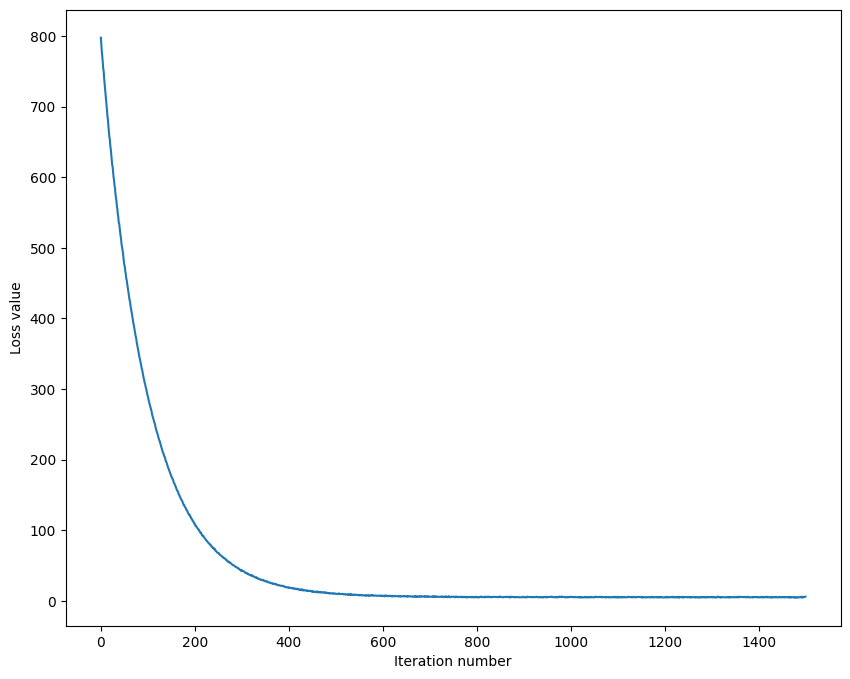

In [14]:
# A useful debugging strategy is to plot the loss as a function of iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the training and validation set
y_train_pred = svm.predict(X_train)
y_val_pred = svm.predict(X_val)
print("training accuracy: %f" % (np.mean(y_train == y_train_pred), ))
print("validation accuracy: %f" % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.369082
validation accuracy: 0.383000


In [16]:
try:
    from tqdm.notebook import tqdm_notebook
except ModuleNotFoundError:
    !pip install tqdm

In [36]:
# Use the validation set to tune hyperparameters (regularization strength and learning rate)
# You should experiment with different ranges for the learning rates and regularization strengths;
# if you are careful, you should be able to get a classification accuracy of about 0.39 (> 0.38)
# on the validation set.

# Note: You may see runtime/overflow warnings during hyperparameter search.
# This may be caused by extreme values, and is not a bug

# Results are dictionary mapping tuples of the form (learning_rate, regularization_strength)
# to tuple of the form (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1  # The highest validation accuracy that we have seen so far.
best_svm = None  # The LinearSVM object that achieved the highest validation accuracy.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
# learning_rates = [2e-5, 1e-4, 2.5e-4, 1e-3, 2.5e-3, 1e-2]
learning_rates = [2.5e-7, 1e-7, 5e-6, 1e-6, 1e-5]
regularization_strengths = [2.5e4, 2e4, 1e4, 8e3, 5e3, 1e3]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for lr in tqdm_notebook(learning_rates, desc="Learning Rate"):
    for reg in tqdm_notebook(regularization_strengths, desc="Regularization strength", leave=False):
        svm = LinearSVM()
        svm.train(
            X=X_train, y=y_train, num_iters=1500,
            learning_rate=lr, reg=reg
        )
        y_train_pred = svm.predict(X=X_train)
        y_val_pred = svm.predict(X=X_val)

        train_accuracy = np.mean(y_train == y_train_pred)
        val_accuracy = np.mean(y_val == y_val_pred)

        results[(lr, reg)] = (train_accuracy, val_accuracy)
        if val_accuracy > best_val:
            best_val = val_accuracy
            best_svm = svm

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

Learning Rate:   0%|          | 0/5 [00:00<?, ?it/s]

Regularization strength:   0%|          | 0/6 [00:00<?, ?it/s]

Regularization strength:   0%|          | 0/6 [00:00<?, ?it/s]

Regularization strength:   0%|          | 0/6 [00:00<?, ?it/s]

Regularization strength:   0%|          | 0/6 [00:00<?, ?it/s]

Regularization strength:   0%|          | 0/6 [00:00<?, ?it/s]

lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.313673 val accuracy: 0.316000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.372204 val accuracy: 0.377000
lr 1.000000e-07 reg 8.000000e+03 train accuracy: 0.377816 val accuracy: 0.386000
lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.377367 val accuracy: 0.393000
lr 1.000000e-07 reg 2.000000e+04 train accuracy: 0.372286 val accuracy: 0.373000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.370735 val accuracy: 0.380000
lr 2.500000e-07 reg 1.000000e+03 train accuracy: 0.370735 val accuracy: 0.363000
lr 2.500000e-07 reg 5.000000e+03 train accuracy: 0.384571 val accuracy: 0.370000
lr 2.500000e-07 reg 8.000000e+03 train accuracy: 0.381286 val accuracy: 0.399000
lr 2.500000e-07 reg 1.000000e+04 train accuracy: 0.380041 val accuracy: 0.377000
lr 2.500000e-07 reg 2.000000e+04 train accuracy: 0.352367 val accuracy: 0.376000
lr 2.500000e-07 reg 2.500000e+04 train accuracy: 0.357061 val accuracy: 0.359000
lr 1.000000e-06 reg 1.000000

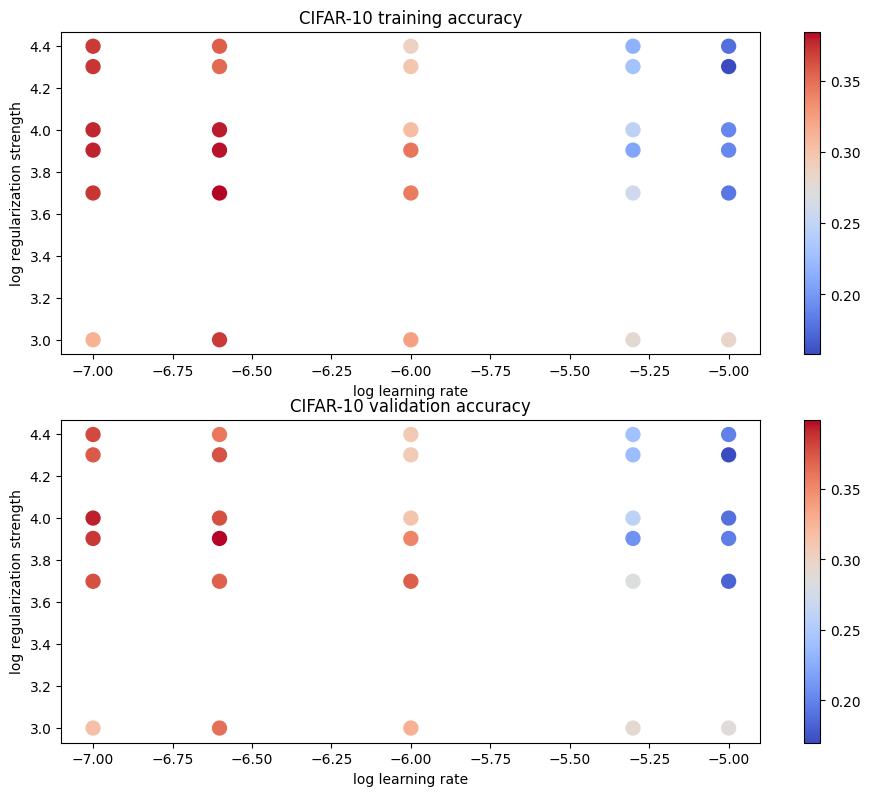

In [37]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# Plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results]  # the default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [38]:
# Evaluate the best svm on the test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.369500


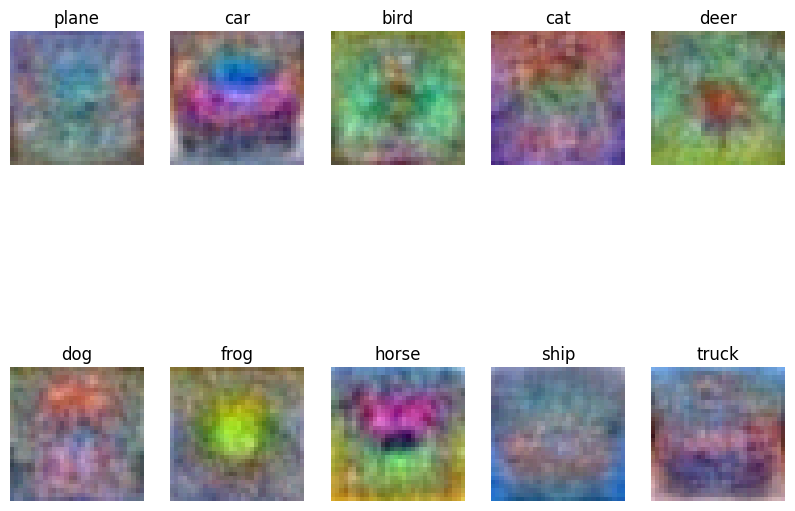

In [39]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1, :]  # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):  # for each and every class
    plt.subplot(2, 5, i + 1)

    # Rescale the weights to be between 0 and 255. To do that we first need to convert the weights between 0 and 1,
    # and then we can multiply with 255.
    w_img = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(w_img.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

plt.show()

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look the way they do.

$\textcolor{yellow}{\textit Your Answer:}$ *Not much, Here are my takeaways though*
* the ship has a blue background in the bottom, so it makes sense
* frog is of green color so somewhat ok.
* horse is like a flower that's funny but not ok.
* Others are barely even recognizable
